# Radiomic Feautre Extraction - Pyradiomics

## Libraries

In [36]:
import pydicom
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import numpy as np

import matplotlib.pyplot as plt

## Functions

Image Re-sampling

In [37]:
def image_down_sample(sitk_img, new_spacing):
    original_spacing = sitk_img.GetSpacing()
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetDefaultPixelValue(0)
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize([int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(sitk_img.GetSize(), original_spacing, new_spacing)])
    resample_filter.SetOutputDirection(sitk_img.GetDirection())
    resample_filter.SetOutputOrigin(sitk_img.GetOrigin())
    resample_filter.SetInterpolator(sitk.sitkLinear if sitk_img.GetPixelIDValue() != sitk.sitkUInt8 else sitk.sitkNearestNeighbor)

    resampled_img = resample_filter.Execute(sitk_img)
    return resampled_img


Add padding to mask image

In [38]:
def mask_padding(mask_image, margin_size):
    """
    Adds an inner margin of zeros to a binary mask within the original size.
    
    Parameters:
        mask_image (sitk.Image): The input 3D SimpleITK binary mask (values of 1 inside the mask).
        margin_size (int): The width of the inner zero margin to add around the edges of each slice in x and y dimensions.

    Returns:
        sitk.Image: A new 3D mask with the specified inner zero margin added, keeping the original image size.
    """
    # Convert the SimpleITK image to a NumPy array
    mask_array = sitk.GetArrayFromImage(mask_image)
    
    # Apply the inner zero margin by setting pixels in the margin area to zero
    # Leave the center region with a value of 1
    mask_array[:, margin_size:-margin_size, margin_size:-margin_size] = 1  # Center region remains 1
    mask_array[:, :margin_size, :] = 0  # Top x margin
    mask_array[:, -margin_size:, :] = 0  # Bottom x margin
    mask_array[:, :, :margin_size] = 0  # Left y margin
    mask_array[:, :, -margin_size:] = 0  # Right y margin
    
    # Convert the modified array back to a SimpleITK image
    padded_mask = sitk.GetImageFromArray(mask_array)
    padded_mask.CopyInformation(mask_image)  # Retain original spacing, origin, and direction metadata
    
    return padded_mask

# Loading Image

Convert DICOM File to NRRD (used for pyradiomics) - converting single series into 3D nnrd file

In [39]:
image_path = '/Users/dhruvgupta/Documents/GitHub/BromptonML/ANON_8bb2a34a27bb4b1a8a450e2f185e830c/DIR000/00000002'

# Load DICOM series from a directory
dicom_reader = sitk.ImageSeriesReader()
dicom_files = dicom_reader.GetGDCMSeriesFileNames(image_path)
dicom_reader.SetFileNames(dicom_files)
image_3d = dicom_reader.Execute()

# Save as NRRD
sitk.WriteImage(image_3d, "output_image.nrrd")
imagePath3D = '/Users/dhruvgupta/Documents/GitHub/BromptonML/output_image.nrrd'

Extract a SINGLE 2D slice

In [40]:
# Extract a 2D slice from the middle of the 3D image
slice_index = image_3d.GetSize()[2] // 2  # Middle slice index
image_2d = image_3d[:, :, slice_index]

# Save the 2D slice as an image (e.g., PNG or NRRD)
sitk.WriteImage(image_2d, "output_image_2d.nrrd")
imagePath2D = "/Users/dhruvgupta/Documents/GitHub/BromptonML/output_image_2d.nrrd"

Visualise the Image loaded

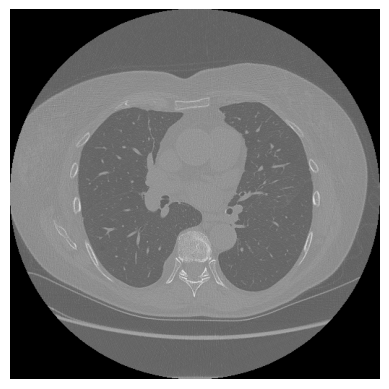

In [41]:
# Load the NRRD file
image = sitk.ReadImage(imagePath2D)

# Convert to a NumPy array
image_array = sitk.GetArrayFromImage(image)

# Display 2D Slice
plt.imshow(image_array, cmap="gray")
plt.axis("off")
plt.show()

## 2D Feature Extractor

Create the image mask with small padding

In [42]:
# Load the 2D image
im = sitk.ReadImage(imagePath2D)
image_size = im.GetSize()[::-1]  # Get image size in z, y, x format

# Create a mask with all values set to 1
ma_arr = np.ones(image_size, dtype=np.uint8)

# Create a smaller mask within the center of the image dimensions
trim_margin = 2  # Adjust the margin as needed
trimmed_ma_arr = ma_arr[trim_margin:-trim_margin, trim_margin:-trim_margin]

# Pad the trimmed array back to the original size with zeros
padded_ma_arr = np.pad(trimmed_ma_arr, pad_width=trim_margin, mode='constant', constant_values=0)

# Create mask image and copy information
ma = sitk.GetImageFromArray(padded_ma_arr)
ma.CopyInformation(im)
ma = sitk.Cast(ma, sitk.sitkUInt8)

# Verify the mask size and unique values
print("Mask size:", ma.GetSize())
print("Unique values in mask:", np.unique(sitk.GetArrayFromImage(ma)))


Mask size: (512, 512)
Unique values in mask: [0 1]


Visualise Mask for entire image

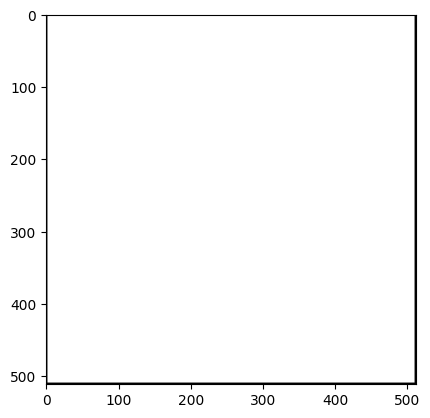

In [43]:
import matplotlib.pyplot as plt

ma_arr = sitk.GetArrayFromImage(ma)
plt.imshow(ma_arr, cmap='grey')  # View a middle slice
plt.show()

In [44]:
# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['label'] = 1  # Extract features for label 1
extractor.enabledFeatures = {'firstorder': [], 'glcm': []}  # Specify feature groups
#extractor.settings['force2D'] = False  # Ensure 3D extraction

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)




Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': []}


In [45]:
# Run the feature extraction
result = extractor.execute(im, ma)
print(result)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'), ('diagnostics_Versions_Numpy', '1.26.4'), ('diagnostics_Versions_SimpleITK', '2.4.0'), ('diagnostics_Versions_PyWavelet', '1.7.0'), ('diagnostics_Versions_Python', '3.10.14'), ('diagnostics_Configuration_Settings', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}), ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}), ('diagnostics_Image-original_Hash', 'dfd3efdc446f5fd7bf12070e34245ef3ad54f405'), ('diagnostics_Image-original_Dimensionality', '2D'), ('diagnostics_Image-original_Spacing', (0.716797, 0.716797)), ('diagnostics_Image-original_Size', (512, 512)), ('diagnostics_Image-original_Mean', -1019.1750297546387), ('diagnostics_Imag

In [46]:
# Access individual variables from the result dictionary
for feature_name, value in result.items():
    print(f"{feature_name}: {value}")

# Example: Access specific feature variables
firstorder_mean = result.get('original_firstorder_Mean')
glcm_contrast = result.get('original_glcm_Contrast')

# Print specific features
print("First-order Mean:", firstorder_mean)
print("GLCM Contrast:", glcm_contrast)

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.26.4
diagnostics_Versions_SimpleITK: 2.4.0
diagnostics_Versions_PyWavelet: 1.7.0
diagnostics_Versions_Python: 3.10.14
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: dfd3efdc446f5fd7bf12070e34245ef3ad54f405
diagnostics_Image-original_Dimensionality: 2D
diagnostics_Image-original_Spacing: (0.716797, 0.716797)
diagnostics_Image-original_Size: (512, 512)
diagnostics_Image-original_Mean: -1019.1750297546387
diagnostics_Image-original_Minimum: -3024.0
diagnostics_Image-original_Maximum: 2236.0
diagnostics_Mask-o

## 3D Feature Extractor

Load 3D image

In [47]:
# Load the 3D image
im = sitk.ReadImage(imagePath3D)
image_size = im.GetSize()[::-1]  # Get image size in z, y, x format (normally x,y,z)

print(im.GetSize()) #x,y,z
print(im.GetSize()[::-1])# z,y,x

# Create a mask with all values set to 1
ma_arr = np.ones(image_size, dtype=np.uint8)

ma = sitk.GetImageFromArray(ma_arr)

ma = mask_padding(ma, margin_size=2)

# Create a smaller mask within the center of the image dimensions
#trim_margin = 2  # Adjust the margin as needed
#trimmed_ma_arr = ma_arr[trim_margin:-trim_margin, trim_margin:-trim_margin, trim_margin:-trim_margin]

# Pad the trimmed array back to the original size with zeros
#padded_ma_arr = np.pad(trimmed_ma_arr, pad_width=trim_margin, mode='constant', constant_values=0)

# Create mask image and copy information
#ma = sitk.GetImageFromArray(padded_ma_arr)
ma.CopyInformation(im)
ma = sitk.Cast(ma, sitk.sitkUInt8)



(512, 512, 484)
(484, 512, 512)


Reduce Image Resolution

In [48]:
# Downsample `im` (image) and `ma` (mask)
new_spacing = (3.0, 3.0, 0.625)  # Example spacing for downsampling
im = image_down_sample(im, new_spacing)
ma = image_down_sample(ma, new_spacing)

# Verify downsampled sizes
print("Downsampled image size:", im.GetSize())
print("Downsampled mask size:", ma.GetSize())

Downsampled image size: (122, 122, 484)
Downsampled mask size: (122, 122, 484)


Run Feature Extractor

In [49]:
# Verify the mask size and unique values
print("Mask size:", ma.GetSize())
print("Unique values in mask:", np.unique(sitk.GetArrayFromImage(ma)))

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['label'] = 1  # Extract features for label 1
extractor.settings['force2D'] = False  # Ensure 3D extraction
#extractor.enabledFeatures = {'firstorder': [], 'glcm': []}

# Run the feature extraction
result_3D = extractor.execute(im, ma)
print(result_3D)

Mask size: (122, 122, 484)
Unique values in mask: [0 1]


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'), ('diagnostics_Versions_Numpy', '1.26.4'), ('diagnostics_Versions_SimpleITK', '2.4.0'), ('diagnostics_Versions_PyWavelet', '1.7.0'), ('diagnostics_Versions_Python', '3.10.14'), ('diagnostics_Configuration_Settings', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}), ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}), ('diagnostics_Image-original_Hash', 'e2041650ba137babcc09e4a3365d692217489901'), ('diagnostics_Image-original_Dimensionality', '3D'), ('diagnostics_Image-original_Spacing', (3.0, 3.0, 0.625)), ('diagnostics_Image-original_Size', (122, 122, 484)), ('diagnostics_Image-original_Mean', -1007.0983957758178), ('diagnostics_Im

Print Feature Values

In [50]:
# Example: Access specific feature variables
firstorder_mean = result_3D.get('original_firstorder_Mean')
glcm_contrast = result_3D.get('original_glcm_Contrast')

# Print specific features
print("First-order Mean:", firstorder_mean)
print("GLCM Contrast:", glcm_contrast)

# Access individual variables from the result dictionary
for feature_name, value in result_3D.items():
    print(f"{feature_name}: {value}")


First-order Mean: -976.3782560973062
GLCM Contrast: 174.20043531075208
diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.26.4
diagnostics_Versions_SimpleITK: 2.4.0
diagnostics_Versions_PyWavelet: 1.7.0
diagnostics_Versions_Python: 3.10.14
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: e2041650ba137babcc09e4a3365d692217489901
diagnostics_Image-original_Dimensionality: 3D
diagnostics_Image-original_Spacing: (3.0, 3.0, 0.625)
diagnostics_Image-original_Size: (122, 122, 484)
diagnostics_Image-original_Mean: -1007.0983957758178
diagnostics_Image-original_Minim

Visualise Down-Sampled 3D image

(484, 122, 122)
242


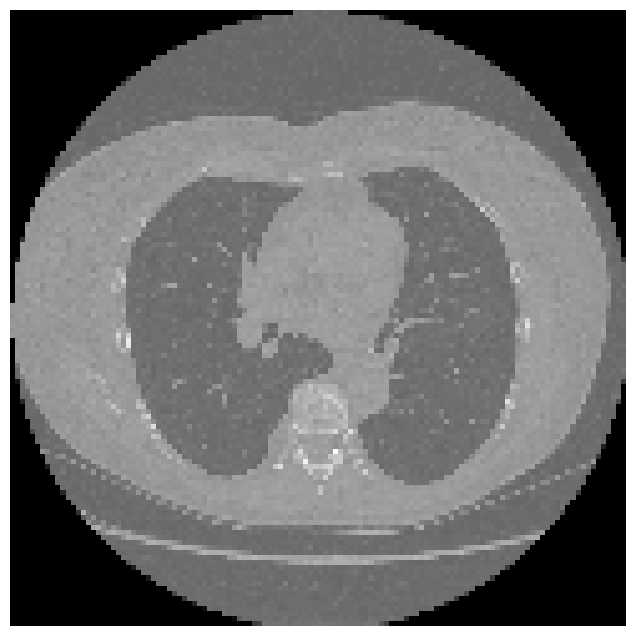

In [51]:
# Load the NRRD file

# Convert to a NumPy array
image_array_dwn = sitk.GetArrayFromImage(im)
print(image_array_dwn.shape)

middle_slice_index = image_array_dwn .shape[0] // 2  # Assuming z-axis slice
print(middle_slice_index)

# Display 2D Slice
plt.figure(figsize=(8, 8))
plt.imshow(image_array_dwn[middle_slice_index, :, :], cmap='gray')
plt.axis("off")
plt.show()

# Loop Through each slice in 3D image

Confirm mask slice

(484, 122, 122)
Unique values in mask: [0 1]


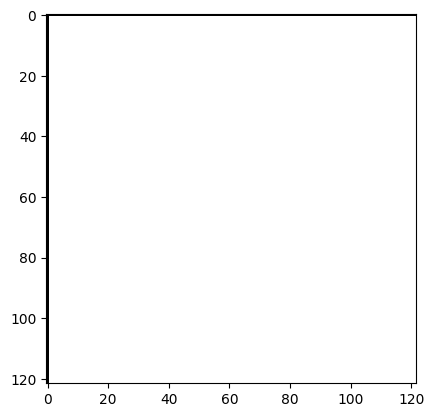

In [ ]:
im_array = sitk.GetArrayFromImage(im)  # Convert to a NumPy array for easier slicing
ma_array = sitk.GetArrayFromImage(ma)  # Convert to a NumPy array for easier slicing

print("Unique values in mask:", np.unique(ma_array))

plt.imshow(ma_array[1, :, :], cmap='grey')  # View a middle slice
plt.show()

Loop for each slice

In [ ]:
# Load the 3D image
#im = sitk.ReadImage(imagePath3D)
im_array = sitk.GetArrayFromImage(im)  # Convert to a NumPy array for easier slicing
ma_array = sitk.GetArrayFromImage(ma)  # Convert to a NumPy array for easier slicing

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['label'] = 1  # Extract features for label 1
extractor.settings['force2D'] = True  # Ensure 2D extraction per slice

# Iterate through each slice in the 3D image
results = []
for i in range(im_array.shape[0]):  # Iterate over the z-axis (slices)
    # Extract the 2D slice from the 3D image and mask
    slice_image = sitk.GetImageFromArray(im_array[i, :, :])
    slice_mask = sitk.GetImageFromArray(ma_array[i, :, :])

    # Run feature extraction on each downsampled slice
    result_slice = extractor.execute(slice_image, slice_mask)
    results.append(result_slice)

# Print the features for each slice
for idx, result in enumerate(results):
    print(f"Features for slice {idx}:")
    print(result)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

Features for slice 0:
OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'), ('diagnostics_Versions_Numpy', '1.26.4'), ('diagnostics_Versions_SimpleITK', '2.4.0'), ('diagnostics_Versions_PyWavelet', '1.7.0'), ('diagnostics_Versions_Python', '3.10.14'), ('diagnostics_Configuration_Settings', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': True, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}), ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}), ('diagnostics_Image-original_Hash', '4c37452c2b94ead918862c952c4c8eba1db3b9de'), ('diagnostics_Image-original_Dimensionality', '2D'), ('diagnostics_Image-original_Spacing', (1.0, 1.0)), ('diagnostics_Image-original_Size', (122, 122)), ('diagnostics_Image-original_Mean', -890.9952969631819), ('diagno

Look at Clustering